In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, sys, shutil
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoost, CatBoostClassifier
from xgboost import plot_importance
from typing import Tuple
from utility import *
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.feature_selection import SelectFromModel, f_classif, SelectKBest, RFE
warnings.filterwarnings("ignore")

In [2]:
# 读入数据并打乱，保证数据的随机性
train = pd.read_csv('../preprocessed/combined_features_256.csv')
test = pd.read_csv('../preprocessed/combined_features_256_test.csv')
train = shuffle(train, random_state=42)
# 连续变量归一化处理
# scaler = StandardScaler()
labels = train['label']

features = train.drop('label', axis=1)
# features_col = features.columns
# print(features_col)
# features = scaler.fit_transform(features)
# 数据集分割
# x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
x_train = features
y_train = labels
y_test  = test['label']
x_test  = test.drop('label', axis=1)

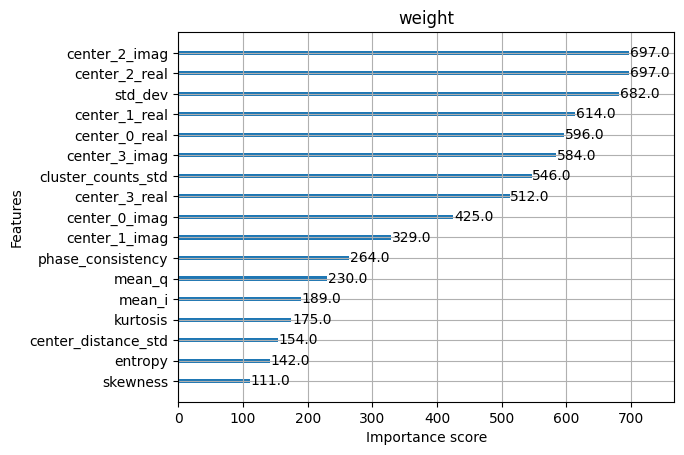

In [3]:
# 1. 使用XGBoost的内置特征重要性
# 训练模型
# x_train = pd.DataFrame(x_train, columns=features_col)
# x_test = pd.DataFrame(x_test, columns=features_col)
model = xgb.XGBClassifier()
model.fit(x_train, y_train)
# 打印特征重要性
# weight：特征在所有树中用作分裂特征的次数。
# gain：特征用作分裂特征时带来的平均增益。
# cover：特征用作分裂特征时覆盖的平均样本数量。
importance_type = 'weight'
importances = model.get_booster().get_score(importance_type=importance_type)  # 或 'gain' 或 'cover' 或 'weight'
importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
# 可视化特征重要性
plot_importance(model, importance_type=importance_type)
plt.title(importance_type)
plt.show()
# print(len(importances))

In [4]:
params =  {'booster': 'dart',
           'lambda': 0.001642503154410547, 
           'alpha': 2.8456229527881028e-08, 
           'subsample': 0.3431387440085293, 
           'colsample_bytree': 0.5217278257570154, 
           'learning_rate': 0.026933381156000847, 
           'n_estimators': 815, 
           'max_depth': 14, 
           'eta': 0.06455751355230073, 
           'gamma': 0.06478402966069816, 
           'grow_policy': 'depthwise', 
           'sample_type': 'weighted', 
           'normalize_type': 'forest',
           'rate_drop': 1.0795037051330119e-05, 
           'skip_drop': 3.654340342849924e-05}

In [5]:

sorted_feature = [_[0] for _ in importances][:3]
x_train = x_train[sorted_feature]
x_test  = x_test[sorted_feature]

xgb_c = xgb.XGBClassifier(eval_metric='logloss')
xgb_c.fit(x_train, y_train)
xgb_pred = xgb_c.predict(x_test)
y_pred = xgb_c.predict_proba(x_test)
xgb_accuracy = accuracy_score(xgb_pred, y_test)

xgb_accuracy

0.88925

In [6]:
# 2. 递归特征消除 (RFE)
# 创建RFE对象

rfe = RFE(estimator=xgb.XGBClassifier(eval_metric='logloss'), n_features_to_select=7)
rfe.fit(x_train, y_train)

pre = rfe.predict(x_test)
accuracy_score(pre, y_test)


0.88925

In [7]:
xgb_c = xgb.XGBClassifier(**params)
xgb_c.fit(x_train, y_train)
xgb_pred = xgb_c.predict(x_test)
y_pred = xgb_c.predict_proba(x_test)
xgb_accuracy = accuracy_score(xgb_pred, y_test)
# xgb_pred
xgb_accuracy


0.87925